# Meta Analysis of the Datasets for the Epi² pilot project 

---
# Cross analysis of datasets

---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 04/08/2016

---
## Import general package and definition of specific functions

In [36]:
# Local lib import
from pycl import *
from pyBioPlot import *

# Standard lib imports
from glob import glob
from collections import OrderedDict
import colorsys

# Third party import
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Larger display 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Allow to use R directly
%load_ext rpy2.ipython

# Simplify warning reporting to lighten the notebook style 
import warnings
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


---
## Comparison lncRNA PTM datasets / lncRNA Localization at gene level

### PTM datasets
**For the moment I only have datasets at gene level from the original studies.**

In [2]:
# parsing file to get the dataset I have
d = OrderedDict()
for fp in glob("./PTM_Annotated_Datasets/*lncRNAs_gene_uniq-gene.csv"):
    ls = supersplit(file_name(fp), ["_", "."])    
    author = ls[0]
    ptm = ls[1]
    cell = ls[2]
    file = "_".join(ls[7:])
    
    if ptm not in d:
        d[ptm] = OrderedDict()   
    if cell not in d[ptm]:
        d[ptm][cell] = OrderedDict()
    if author not in d[ptm][cell]:
        d[ptm][cell][author] = []
    d[ptm][cell][author].append(fastcount(fp))
    
print(dict_to_report(d))

A>I
	Brain
		Sakurai:[319]
	YH
		Peng:[505]
	various
		DARNED:[1300]
		RADAR:[3343]
Y
	HEK293
		Li:[44]
	HEK293:Fibroblast
		Schwartz:[10]
	HeLa
		Carlile:[3]
m1A
	HeLa:HEK293:HepG2
		Dominissini:[338]
m5C
	HEK293
		Hussain:[39]
	HeLa
		Squires:[112]
	MEF
		Khoddami:[36]
m6A
	HEK293
		Meyer:[16]
	HepG2
		Dominissini:[84]
m6A:m6Am
	HEK293
		Linder:[168]



**I will first try to plot all the results regardless of their cell line of origin just to see if there is any specific pattern**

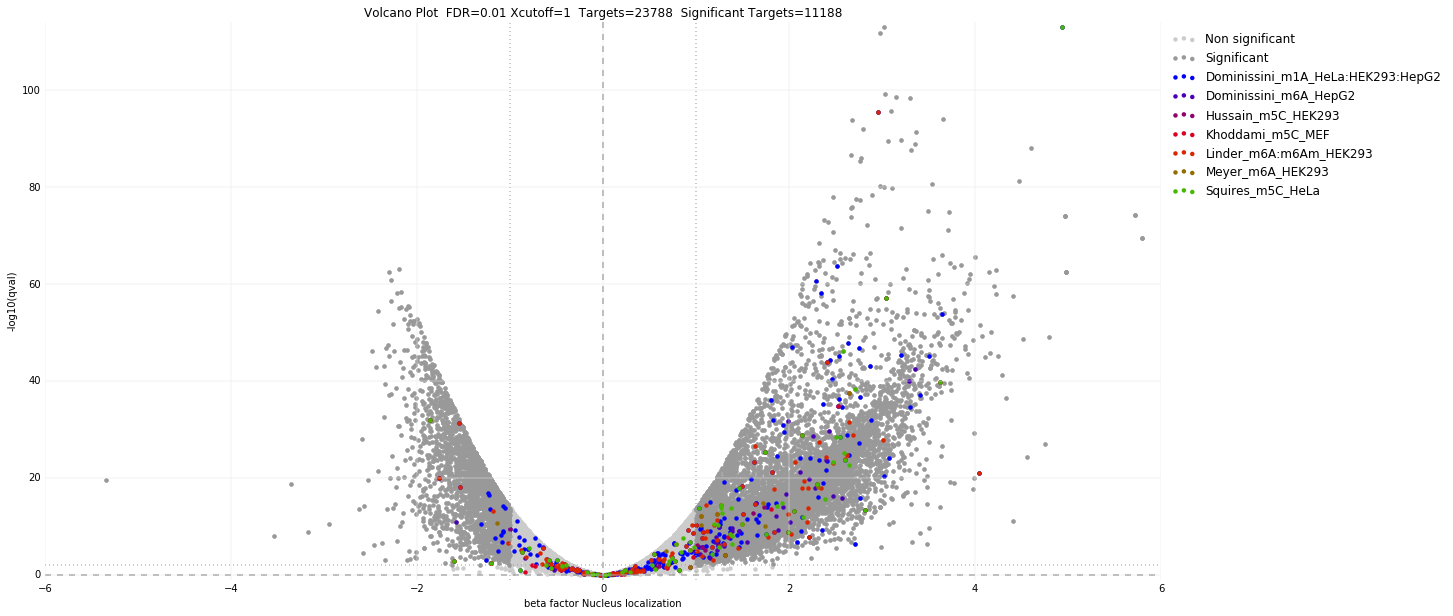

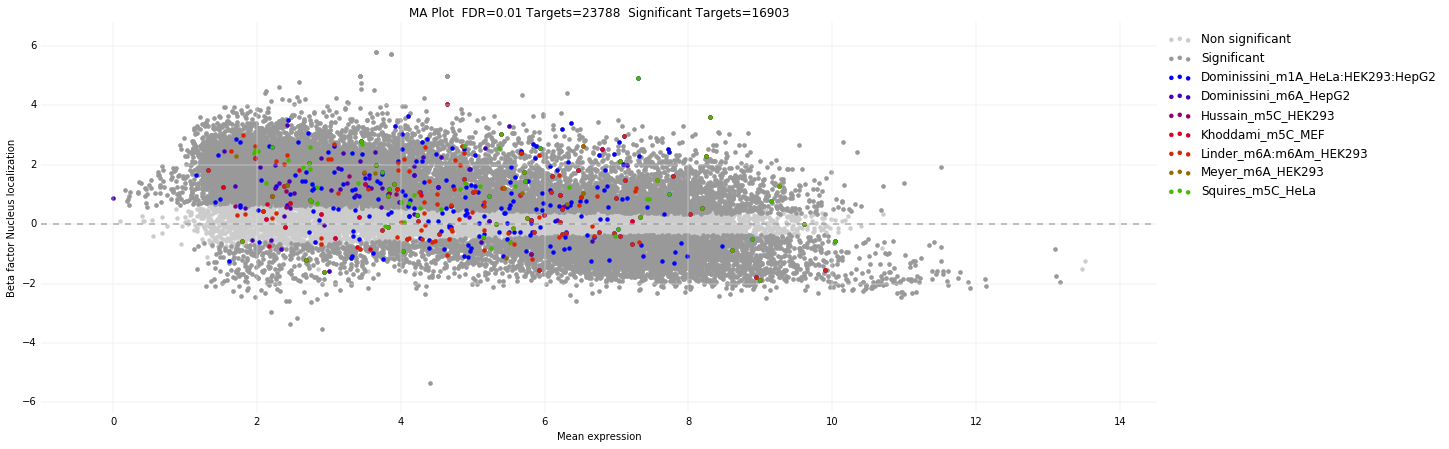

In [23]:
df = pd.read_table("./Localisation_Original_Datasets/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")

PTM_dataset_list = sorted(glob("./PTM_Annotated_Datasets/*_m*lncRNAs_gene_uniq-gene.csv"))
colors = get_color_list(len(PTM_dataset_list), "brg")
hl=[]
for fp, color in zip(PTM_dataset_list, colors):
    PTM_df = pd.read_table(fp, names=["target_id", "gene_name", "count"])
    PTM_id = file_name(fp).split("_hg38_")[0]
    hl.append({ "target_id": PTM_df.target_id, "color":color, "label":PTM_id})
    
volcano_plot (df=df, highlight_list=hl, X="b", Y="qval", FDR=0.01, X_cutoff=1, figsize=[20,10],
              xlabel = "beta factor Nucleus localization", sig_color="0.6", non_sig_color="0.8", xlim=[-6,6])
MA_plot (df=df, highlight_list=hl, X="mean_obs", Y="b", FDR=0.01, FDR_col="qval", figsize=[20,7],
         xlabel="Mean expression", ylabel="Beta factor Nucleus localization", sig_color="0.6", non_sig_color="0.8")

using a non-integer number instead of an integer will result in an error in the future


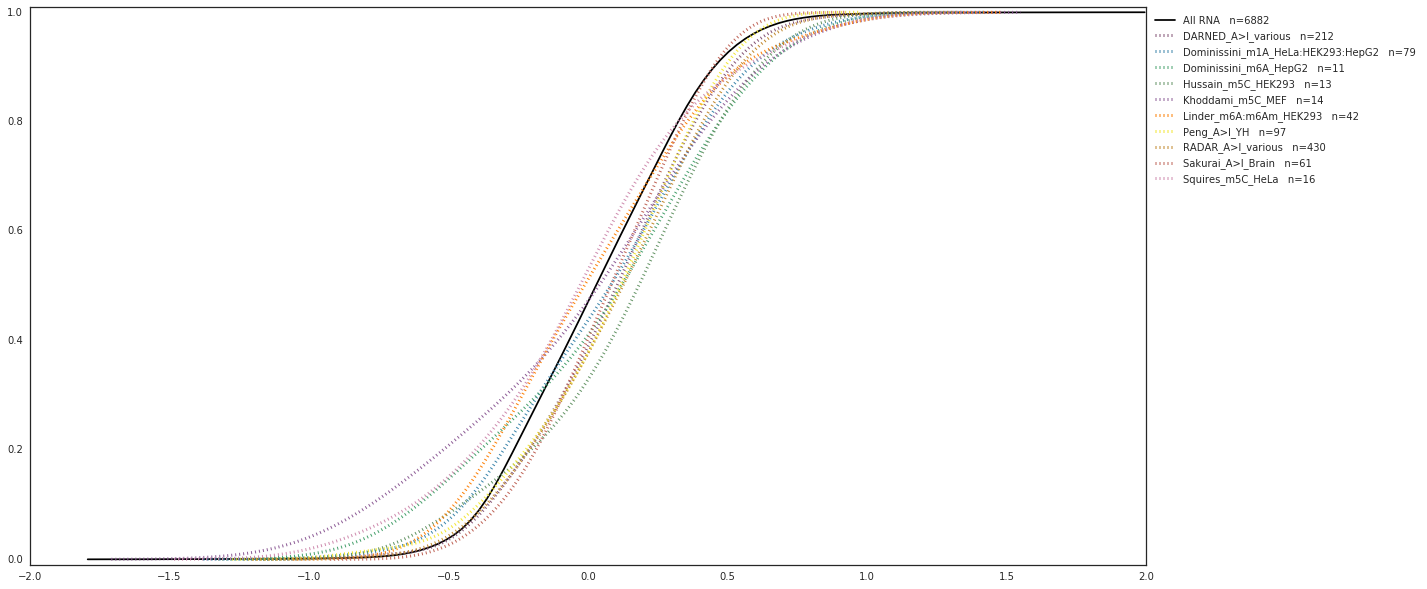

In [66]:
sns.set(style="white")
pl.figure(figsize=[20,10],frameon=False)
pl.ylim(-0.01,1.01)

df = pd.read_table("./Localisation_Original_Datasets/Djebali-ENCODE/sleuth/gene_allRNA/ALL/localizationnucleus_wald_test.tsv")
df = df[(df.qval>=0.01)]
label = "All RNA   n={}".format(len(df))
sns.kdeplot(df.b, cumulative=True, c="black", label= label)

PTM_dataset_list = sorted(glob("./PTM_Annotated_Datasets/*lncRNAs_gene_uniq-gene.csv"))
colors = get_color_list(len(PTM_dataset_list), "Set1")
for fp, color in zip(PTM_dataset_list, colors):
    PTM_df = pd.read_table(fp, names=["target_id", "gene_name", "count"])
    sub_df = pd.merge(PTM_df, df, how='inner', on='target_id')
    if len(sub_df) > 10:
        PTM_id = "{}   n={}".format(file_name(fp).split("_hg38_")[0], len(sub_df))
        sns.kdeplot(sub_df.b, cumulative=True, c=color, label=PTM_id, linestyle=":", linewidth=3)

pl.legend(bbox_to_anchor=(1, 1), loc=2, frameon=False)
    

---
## Comparison lncRNA PTM datasets / lncRNA Localization at transcript level


**Considering the methods used by most of the genome wide PTM investigation I don't know if it is possible to determine the transcript of origin of the modified RNA ?? Possibility to use Kallisto or other methods eventually perform a transcript level analysis.**
*
*


###  Summary dataset 2
*
*